In [181]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("pastel") 

### Загрузка данных

In [182]:
data = pd.read_csv('data/ds_salaries.csv')
data.head(1)

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L


In [183]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


## Формирование отчета

Для рассмотрения общей структуры и первичной оценке данных, сформируем отчет

In [202]:
# Отчет уже сформирован.
# Если возникла необходимость пересоздать(проверить), просто раскомментируйте и запустите
# profile = ProfileReport(data)
# profile.to_file('./data/DS_salary_analyze_before.html')

Рассмотрим корреляционную матрицу:  
![Корреляционная матрица данных по зарплатам](/data/corr_heatmap.jpg)

In [200]:
# Отбор категорий, в которых больше чем 90% занимает одна величина
high_freq_categories = []
for column in data.columns:
    freqency = data[column].value_counts(normalize=True)
    if not freqency[freqency > 0.9].empty:
        high_freq_categories.append(column)

display(high_freq_categories)   


[]

In [201]:
data = data.drop(['Unnamed: 0', 'salary', 'salary_currency', 'company_location', 'employment_type'], axis=1)

KeyError: "['Unnamed: 0', 'salary', 'salary_currency', 'company_location', 'employment_type'] not found in axis"

In [187]:
data = data.drop_duplicates()

Из таблицы корреляции можно сказать, что у нас практически нет связи между переменными.

In [188]:
# data['work_year'].value_counts()

В данных все признаки являются категориальными, кроме:
* salary_in_usd - заработная плата в USD

Несмотря на то, что значения признака *remote_ratio* предсавлены числами, он является **категориальным**. Это связано с тем, что данный признак принимает значения-ярлыки, которые просто представляют разные уровни удаленной работы.
Тоже самое можно сказать признак *work_year* - он является **категориальным**. Потому что мы рассматриваем не временной промежутоки тенденции изменения от года к году, а просто 3 группы работников, которые получали зарплату за определенный год (2020, 2021, 2022)


In [189]:
data['remote_ratio'] = data['remote_ratio'].astype('object')
data['work_year'] = data['work_year'].astype('object')


Определим основные статистические характеристики

In [190]:
data.describe(include='all')

,work_year,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_size
count,565.0,565,565,565.000000,565,565.0,565
unique,3.0,4,50,NaN,57,3.0,3
top,2022.0,SE,Data Scientist,NaN,US,100.0,M
freq,278.0,243,130,NaN,295,346.0,290
mean,NaN,NaN,NaN,110610.343363,NaN,NaN,NaN
std,NaN,NaN,NaN,72280.702792,NaN,NaN,NaN
min,NaN,NaN,NaN,2859.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,60757.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,100000.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,150000.000000,NaN,NaN,NaN


In [191]:
profile = ProfileReport(data)
profile.to_file('./data/DS_salary_analyze_after.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

d:\Course_for_DS\EDA_Statistics_test\env\Lib\site-packages\ydata_profiling\model\pandas\summary_pandas.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.fillna(np.nan)
d:\Course_for_DS\EDA_Statistics_test\env\Lib\site-packages\ydata_profiling\model\pandas\summary_pandas.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  series = series.fillna(np.nan)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Визуальный анализ данных

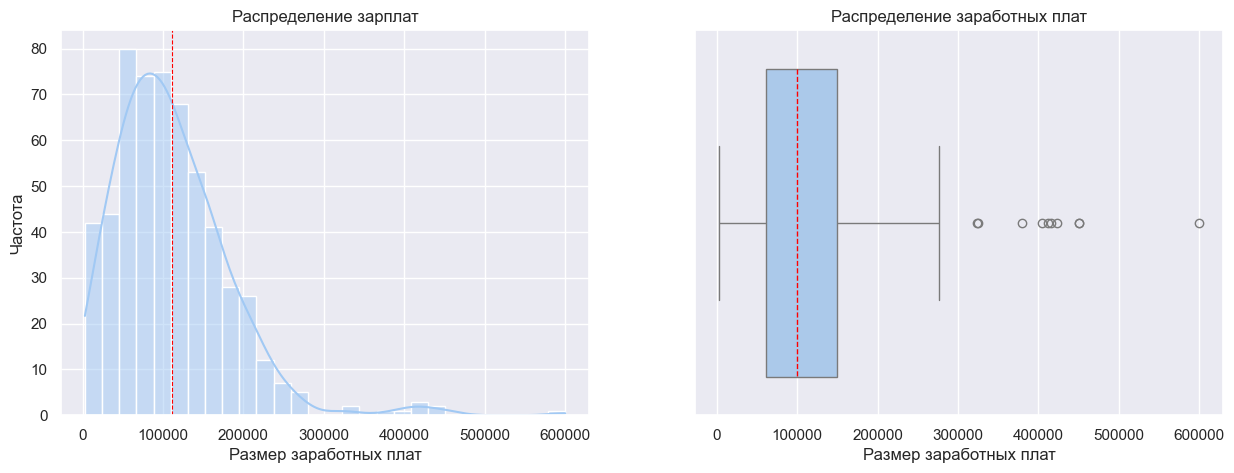

In [192]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработных плат', ylabel='Частота')
axes[0].set_title('Распределение зарплат')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={'color': 'red', 'linestyle': '--'})
axes[1].set(xlabel='Размер заработных плат')
axes[1].set_title('Распределение заработных плат')

plt.show()

In [193]:
shapiro_test = stats.shapiro(data['salary_in_usd'])
print(f'p_value = {round(shapiro_test.pvalue, 3)}')

if shapiro_test.pvalue <= 0.05:
    print('not a normal')
else:
    print('normal')

p_value = 0.0
not a normal


In [194]:
frequent_residences = data['employee_residence'].value_counts().nlargest(10).index.tolist()

data['employee_residence'] = data['employee_residence'].apply(lambda x: x if x in frequent_residences else 'other')
data['employee_residence'].value_counts()

employee_residence
US       295
other     88
GB        43
IN        30
CA        27
DE        24
FR        18
ES        15
GR        12
JP         7
PT         6
Name: count, dtype: int64

In [195]:
# for column in data.columns:
#     if column not in ['salary_in_usd', 'job_title']:

#         plt.figure(figsize=(10, 4))
#         sns.countplot(y=column, data=data)
#         plt.title(f'Distribution of {column}')
#         plt.show()

In [196]:
# top_job_titles = data['job_title'].value_counts().nlargest(10)
# plt.figure(figsize=(10, 6))
# sns.barplot(x=top_job_titles.values, y=top_job_titles.index, palette="Blues_d")

# # Настройка графика
# plt.title('Top 10 Job Titles Distribution', fontsize=14)
# plt.xlabel('Count', fontsize=12)
# plt.ylabel('Job Title', fontsize=12)
# plt.tight_layout()

In [197]:
#
# # report = sv.analyze(data)
# # report.show_html()

In [198]:
#data.info()

In [199]:
data.duplicated().sum()

np.int64(0)